In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: pho
"""
%load_ext autoreload
%autoreload 2
import sys
import importlib
from threading import Thread
import time # for time.sleep
from ipygany import PolyMesh, Scene, IsoColor, WarpByScalar
import pyvista as pv
# from pyvista import _vtk
import pyvistaqt as pvqt
import colorcet as cc # Colormaps:
import numpy as np
import pandas as pd
import h5py
import hdf5storage # conda install hdf5storage
from pathlib import Path
import bqplot.scales
import seaborn as sns
from mpl_toolkits import mplot3d
# %matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize, to_rgba_array
# import mplcursors
import math # For color map generation
from matplotlib.colors import ListedColormap
from matplotlib.cm import hsv

from copy import deepcopy

import ipywidgets as widgets
# from PyQt5 import QtWidgets, uic
from pyvistaqt import QtInteractor, MainWindow
# from pyqt6 import QApplication
from IPython.external.qt_for_kernel import QtGui
from PyQt5.QtWidgets import QApplication
import datetime as dt

import panel as pn # for interactive widgets
# pn.extension()
pn.extension('tabulator')

In [5]:
# NeuroPy (Diba Lab Python Repo) Loading
try:
    from neuropy import core
    importlib.reload(core)
except ImportError:
    sys.path.append(r'C:\Users\Pho\repos\NeuroPy') # Windows
    # sys.path.append('/home/pho/repo/BapunAnalysis2021/NeuroPy') # Linux
    # sys.path.append(r'/Users/pho/repo/Python Projects/NeuroPy') # MacOS
    print('neuropy module not found, adding directory to sys.path. \n >> Updated sys.path.')
    from neuropy import core
# from neuropy.core.session.dataSession import SessionConfig, DataSessionLoader, DataSession, processDataSssion

from neuropy.core.session.data_session_loader import DataSessionLoader
from neuropy.core.session.dataSession import DataSession
from neuropy.core.epoch import Epoch, NamedTimerange
from neuropy.core import Laps
from neuropy.core import Position
from neuropy.core import FlattenedSpiketrains
from neuropy.core import Neurons
from neuropy.utils.misc import print_seconds_human_readable
from neuropy.plotting import plot_raster
## Data must be pre-processed using the MATLAB script located here: 
# R:\data\KDIBA\gor01\one\IIDataMat_Export_ToPython_2021_11_23.m

# From pre-computed .mat files:
## 07: 
basedir = r'R:\data\KDIBA\gor01\one\2006-6-07_11-26-53'

# ## 08:
#basedir = r'R:\data\KDIBA\gor01\one\2006-6-08_14-26-15'

neuropy module not found, adding directory to sys.path. 
 >> Updated sys.path.


In [30]:
# import PhoPositionalData as pdp
# from PhoPositionalData import load_exported, process_data
from PhoPositionalData.load_exported import *
# from PhoPositionalData.process_data import process_positionalAnalysis_data, gen_2d_histrogram, get_heatmap_color_vectors, process_chunk_equal_poritions_data, extract_spike_timeseries
from PhoPositionalData.process_data import *
from PhoPositionalData.plot_data import *
from PhoPositionalData.plotting.animations import * # make_mp4_from_plotter
from PhoPositionalData.import_data import * # build_spike_positions_list, build_cellID_reverse_lookup_map
from PhoPositionalData.analysis.interactive_placeCell_config import InteractivePlaceCellConfig, VideoOutputModeConfig, PlottingConfig, PlacefieldComputationParameters
from PhoPositionalData.analysis.interactive_placeCell_config import print_subsession_neuron_differences

from PendingNotebookCode import debug_print_spike_counts, compute_placefields_as_needed, build_configs, build_units_colormap, build_placefield_multiplotter, process_by_good_placefields

In [7]:
# KDiba Old Format:
sess = DataSessionLoader.kdiba_old_format_session(basedir)
active_sess_config = sess.config
session_name = sess.name

	 basepath: R:\data\KDIBA\gor01\one\2006-6-07_11-26-53
	 session_name: 2006-6-07_11-26-53
Loading matlab import file: R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.epochs_info.mat...
done.
Loading matlab import file: R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.position_info.mat...
done.
Loading matlab import file: R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.spikes.mat...
done.
Loading success: .position.npy.
done.

session.position linear positions computed!
	 Failure loading .interpolated_spike_positions.npy. Must recompute.

	 Saving updated position results to R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.position.npy...
filename can not be None
	 done.

Loading matlab import file: R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.laps_info.mat...
done.
setting laps object.
session.laps loaded successfully!


In [12]:
epochs_df_widget = pn.widgets.Tabulator(sess.epochs.to_dataframe())
laps_df_widget = pn.widgets.Tabulator(sess.laps.to_dataframe())
# position_df_widget = pn.widgets.Tabulator(sess.position.to_dataframe())
# position_df_widget = pn.widgets.Tabulator(sess.position.to_dataframe())
# tabs = pn.Tabs(('epochs',epochs_df_widget), ('laps',laps_df_widget), ('position',position_df_widget), dynamic=True)
# neurons_plot = plot_raster(sess.neurons, color='jet',add_vert_jitter=True)

# tabs = pn.Tabs(('epochs',epochs_df_widget), ('laps',laps_df_widget), ('neurons', neurons_plot), dynamic=False)
# tabs

In [13]:
# sess.spikes_df.size # (1014937, 18)
# np.sum(sess.neurons.n_spikes) # 1014937
print('session dataframe spikes: {}\n session.neurons.n_spikes summed: {}\n'.format(sess.spikes_df.shape, np.sum(sess.neurons.n_spikes)))

session dataframe spikes: (932598, 20)
 session.neurons.n_spikes summed: 932598



## Debugging

In [ ]:
# debug_print_spike_counts(sess)

# sess.spikes_df unique aclu values: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
#  26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
#  50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65]
# sess.spikes_df unique aclu value counts: [    0     0  1707  1359   554  3066 91337  2707   294  2991   913  1278
#   1221  5475  2880 36760 48449   523  2595  3025 34729  3958  5263   790
#    663  1070  1078  2954  4044  2581 73951  4871 13444   476  1234 89854
#   5822 14961  2682  1184 13575 83972   795 22769  1559  8307  2098   438
#   3476 28370 43854  1355  2552  2875 59011  1440 75786  3656   875 17727
#  77247   550   408  2627  1734  2799]

# sess.spikes_df unique unit_id values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
#  24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
#  48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
# sess.spikes_df unique unit_id value counts: [ 1707  1359   554  3066 91337  2707   294  2991   913  1278  1221  5475
#   2880 36760 48449   523  2595  3025 34729  3958  5263   790   663  1070
#   1078  2954  4044  2581 73951  4871 13444   476  1234 89854  5822 14961
#   2682  1184 13575 83972   795 22769  1559  8307  2098   438  3476 28370
#  43854  1355  2552  2875 59011  1440 75786  3656   875 17727 77247   550
#    408  2627  1734  2799]

# sess.neurons.spiketrains
# sess.neurons.n_spikes

## Note the unit_id seems to have valid spikes for all of them, while the aclu does not!
sess.spikes_df # 1014937

sess.laps
# np.where(np.logical_and((sess.spikes_df.maze_relative_lap == 1), (sess.spikes_df.maze_id == 2)))
# sess.spikes_df.lap.values[np.logical_and((sess.spikes_df.maze_relative_lap == 1), (sess.spikes_df.lap_maze == 2))]


# test_df = sess.spikes_df
# test_df

In [ ]:
lap_specific_subsessions = list()
lap_grouped_spikes_df = sess.spikes_df.groupby(['lap']) #  as_index=False keeps the original index

In [ ]:
i = 2
curr_lap_id = sess.laps.lap_id[i]
curr_lap_times = sess.laps.get_lap_times(i)
print('curr_lap_id: {}'.format(curr_lap_id))
print('curr_lap_times: {}'.format(curr_lap_times))

lap_specific_subsessions.append(sess.time_slice(curr_lap_times[0], curr_lap_times[-1]))
# lap_specific_subsessions.append(sess.time_slice(curr_lap_dataframe.t_seconds.values[0], curr_lap_dataframe.t_seconds.values[-1]))

In [ ]:
i = 3
curr_lap_id = sess.laps.lap_id[i]
curr_lap_times = sess.laps.get_lap_times(i)
print('curr_lap_id: {}'.format(curr_lap_id))
print('curr_lap_times: {}'.format(curr_lap_times))

lap_specific_subsessions.append(sess.time_slice(curr_lap_times[0], curr_lap_times[-1]))

In [ ]:
lap_specific_session = DataSession.concat(lap_specific_subsessions)
lap_specific_session

In [ ]:
lap_specific_session.neurons.n_spikes # this looks right.

lap_specific_session.position.print_debug_str() # this looks right.

# len(sess.neurons.n_spikes) # 64 items long
# sess.neurons.n_spikes
# array([ 1707,  1359,   554,  3066, 91337,  2707,   294,  2991,   913,
#         1278,  1221,  5475,  2880, 36760, 48449,   523,  2595,  3025,
#        34729,  3958,  5263,   790,   663,  1070,  1078,  2954,  4044,
#         2581, 73951,  4871, 13444,   476,  1234, 89854,  5822, 14961,
#         2682,  1184, 13575, 83972,   795, 22769,  1559,  8307,  2098,
#          438,  3476, 28370, 43854,  1355,  2552,  2875, 59011,  1440,
#        75786,  3656,   875, 17727, 77247,   550,   408,  2627,  1734,
#         2799])



## Laps: Create version of Session that only includes activity during the laps

In [ ]:
sess.laps.lap_id # 1-80

In [8]:
lap_specific_sessions = sess.split_by_laps()
# lap_specific_session = deepcopy(sess) # copy of session
# lap_specific_session = deepcopy(sess.filtered_by_laps())
# lap_specific_session = sess.filtered_by_laps()
# print(lap_specific_session.neurons.n_spikes)
# print_subsession_neuron_differences(sess.neurons, lap_specific_session.neurons)

Constraining to epoch with times (start: 29.5092789712362, end: 47.6615333572845)
Constraining to epoch with times (start: 58.504551165620796, end: 67.77771633781958)
Constraining to epoch with times (start: 91.70563496672548, end: 123.80089149391279)
Constraining to epoch with times (start: 123.80239677318605, end: 131.3101151692099)
Constraining to epoch with times (start: 272.3169626536546, end: 286.19923138595186)
Constraining to epoch with times (start: 301.72022695920896, end: 308.42351184715517)
Constraining to epoch with times (start: 730.109547463886, end: 757.2724340364803)
Constraining to epoch with times (start: 776.8678211236256, end: 782.8647921332158)
Constraining to epoch with times (start: 839.3915292714955, end: 853.7373625664623)
Constraining to epoch with times (start: 868.4558907105238, end: 874.987942406151)
Constraining to epoch with times (start: 885.2308146017604, end: 901.1212794258608)
Constraining to epoch with times (start: 924.4401129265898, end: 930.41287

In [9]:
even_lap_specific_session = [lap_specific_sessions[i] for i in np.arange(0, len(lap_specific_sessions), 2)]
even_lap_specific_session
# range(0, 2, len(lap_specific_sessions))

[DataSession(2006-6-07_11-26-53.xml),
 DataSession(2006-6-07_11-26-53.xml),
 DataSession(2006-6-07_11-26-53.xml),
 DataSession(2006-6-07_11-26-53.xml),
 DataSession(2006-6-07_11-26-53.xml),
 DataSession(2006-6-07_11-26-53.xml),
 DataSession(2006-6-07_11-26-53.xml),
 DataSession(2006-6-07_11-26-53.xml),
 DataSession(2006-6-07_11-26-53.xml),
 DataSession(2006-6-07_11-26-53.xml),
 DataSession(2006-6-07_11-26-53.xml),
 DataSession(2006-6-07_11-26-53.xml),
 DataSession(2006-6-07_11-26-53.xml),
 DataSession(2006-6-07_11-26-53.xml),
 DataSession(2006-6-07_11-26-53.xml),
 DataSession(2006-6-07_11-26-53.xml),
 DataSession(2006-6-07_11-26-53.xml),
 DataSession(2006-6-07_11-26-53.xml),
 DataSession(2006-6-07_11-26-53.xml),
 DataSession(2006-6-07_11-26-53.xml),
 DataSession(2006-6-07_11-26-53.xml),
 DataSession(2006-6-07_11-26-53.xml)]

In [ ]:
lap_specific_session.flattened_spiketrains

In [ ]:
# lap_specific_session.position
# sess.neurons.spiketrains
sess.flattened_spiketrains.spikes_df

In [ ]:
sess.flattened_spiketrains.spikes_df
neurons_obj = Neurons.from_dataframe(sess.flattened_spiketrains.spikes_df, sess.recinfo.dat_sampling_rate, time_variable_name='t_rel_seconds')
neurons_obj

In [ ]:
## Filtering Testing:
temp_spikes_df = deepcopy(sess.flattened_spiketrains.spikes_df)
curr_lap_spikes_df = temp_spikes_df.loc[temp_spikes_df['lap'] != -1]
curr_lap_spikes_neurons_obj = Neurons.from_dataframe(curr_lap_spikes_df, sess.recinfo.dat_sampling_rate, time_variable_name='t_rel_seconds')
print_subsession_neuron_differences(sess.neurons, curr_lap_spikes_neurons_obj)
# Asign the result to the lap_specific_session
lap_specific_session.flattened_spiketrains = FlattenedSpiketrains(curr_lap_spikes_df, time_variable_name='t_rel_seconds', t_start=0.0)
lap_specific_session.neurons = curr_lap_spikes_neurons_obj

In [10]:
lap_specific_session = deepcopy(DataSession.concat(even_lap_specific_session))
lap_specific_session

!! WARNING: Session.concat(...) is not yet fully implemented, meaning the returned session is not fully valid. Continue with caution.


DataSession(2006-6-07_11-26-53.xml)

# Filter Session by Epoch:

In [31]:
active_epoch = sess.epochs.get_named_timerange('maze1')
# active_epoch = sess.epochs.get_named_timerange('maze2')
# active_epoch = NamedTimerange(name='maze', start_end_times=[sess.epochs['maze1'][0], sess.epochs['maze2'][1]])
active_subplots_shape = (1,1) # Single subplot
# active_subplots_shape = '1|2' # 1 subplot on left, two on right                                                   
active_config = build_configs(active_sess_config, active_epoch, active_subplots_shape = active_subplots_shape)
# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=1, grid_bin=2, smooth=0.5)
active_config.computation_config = PlacefieldComputationParameters(speed_thresh=1, grid_bin=10, smooth=0.5)

## All Spikes:
active_epoch_session = sess.filtered_by_neuron_type('pyramidal').filtered_by_epoch(active_epoch)
print_subsession_neuron_differences(sess.neurons, active_epoch_session.neurons)
print(sess.neurons.n_spikes)

Constraining to units with type: pyramidal
Constraining to epoch with times (start: 0.0, end: 1739.1533641185379)
69892/932598 total spikes spanning 40/64 units remain in subsession
[ 1707  1359   554  3066 91337  2707   294  2991   913  1278  1221  5475
  2880 36760 48449   523  2595  3025 34729  3958  5263   790   663  1070
  1078  2954  4044  2581 73951  4871 13444   476  1234 89854  5822 14961
  2682  1184 13575 83972   795 22769  1559  8307  2098   438  3476 28370
 43854  1355  2552  2875 59011  1440 75786  3656   875 17727 77247   550
   408  2627  1734  2799]


In [32]:
## Lap_specific Spikes Only:
active_lap_specific_epoch_session = lap_specific_session.filtered_by_neuron_type('pyramidal').filtered_by_epoch(active_epoch)
print_subsession_neuron_differences(lap_specific_session.neurons, active_lap_specific_epoch_session.neurons)
print(active_lap_specific_epoch_session.neurons.n_spikes)

Constraining to units with type: pyramidal
Constraining to epoch with times (start: 0.0, end: 1739.1533641185379)
10178/148328 total spikes spanning 40/64 units remain in subsession
[142 681 288 529 187 130 697 297 172  12 157  19 683 100 565  22 407 532
 101  88 937  86  59 206  93 431  82 429 340 267 144  55 230 688 114  81
   4  12  55  56]


## Compute Placefields if needed:

In [ ]:
## ICA and PCA Analysis
should_show_2D_ICA_plots = False
from PhoPositionalData.analysis.neuronal_dimensionality_reduction import runAnalysis_PCAandICA
active_session_ensembles, template, zsc_template, pca_data = runAnalysis_PCAandICA(active_epoch_session.neurons, bin_size=0.250, frate_thresh=0.1, should_plot=should_show_2D_ICA_plots, active_cells_colormap=active_config.plotting_config.active_cells_colormap)

Recomputing active_epoch_placefields...
	 done.
Recomputing active_epoch_placefields2D...
	 done.
Saving 1D Placefield image out to "output\2006-6-07_11-26-53\maze1\1D Placefields - maze1.pdf"...
done.


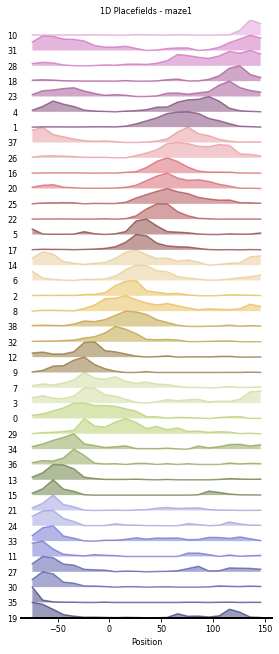

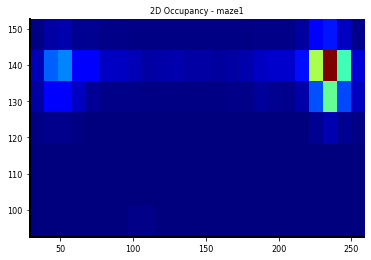

Saving 2D Placefield image out to "output\2006-6-07_11-26-53\maze1\2D Occupancy - maze1.pdf"...
	 done.
Saving 2D Placefield image out to "output\2006-6-07_11-26-53\maze1\2D Placefields - maze1.pdf"...
	 done.
good_placefield_neuronIDs: [ 2  3  4  5  7  8  9 10 11 12 14 17 18 21 22 23 24 25 26 27 28 29 33 34
 38 39 42 44 45 46 47 48 53 55 57 58 61 62 63 64]; (40 good)
active_epoch_session.spikes_df unique aclu values: [ 2  3  4  5  7  8  9 10 11 12 14 17 18 21 22 23 24 25 26 27 28 29 33 34
 38 39 42 44 45 46 47 48 53 55 57 58 61 62 63 64]
active_epoch_session.spikes_df unique aclu value counts: [1596 1276  496 2648 2109  271 2694  814 1140  905 2626  492 2317 3268
 4576  666  621  900  971 2755 3147 2219  442 1092 2289 1085  703 1381
 7238 1899  403 2987 2375 1354 3183  777  437  332 1876 1532]
40
active_epoch_session.spikes_df unique unit_id values: [ 0  1  2  3  5  6  7  8  9 10 12 15 16 19 20 21 22 23 24 25 26 27 31 32
 36 37 40 42 43 44 45 46 51 53 55 56 59 60 61 62]
active_epoch_s

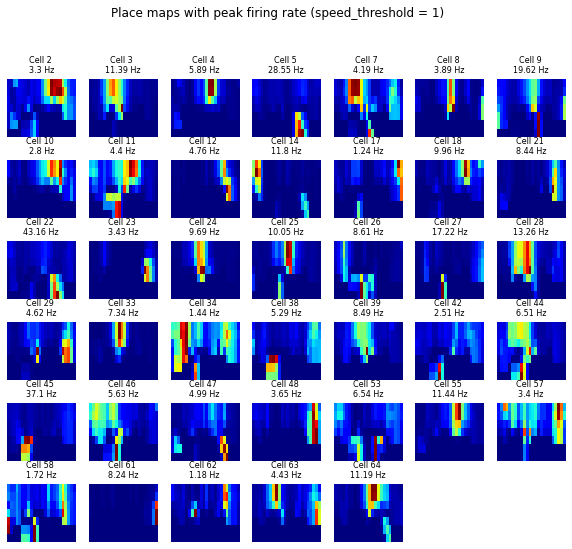

In [39]:
try: active_epoch_placefields1D
except NameError: active_epoch_placefields1D = None # Checks variable active_epoch_placefields's existance, and sets its value to None if it doesn't exist so it can be checked in the next step
try: active_epoch_placefields2D
except NameError: active_epoch_placefields2D = None # Checks variable active_epoch_placefields's existance, and sets its value to None if it doesn't exist so it can be checked in the next step
active_epoch_placefields1D, active_epoch_placefields2D = compute_placefields_as_needed(active_epoch_session, active_config.computation_config, active_config, active_epoch_placefields1D, active_epoch_placefields2D, should_force_recompute_placefields=True, should_display_2D_plots=True)
# Focus on the 2D placefields:
active_epoch_placefields = active_epoch_placefields2D
# Get the updated session using the units that have good placefields
active_epoch_session, active_config, good_placefield_neuronIDs = process_by_good_placefields(active_epoch_session, active_config, active_epoch_placefields)
debug_print_spike_counts(active_epoch_session)

## Compute the placefields for lap-only filtered Session:

Recomputing active_epoch_placefields...
	 done.
Recomputing active_epoch_placefields2D...
	 done.
Saving 1D Placefield image out to "output\2006-6-07_11-26-53\maze1\1D Placefields - maze1.pdf"...
done.


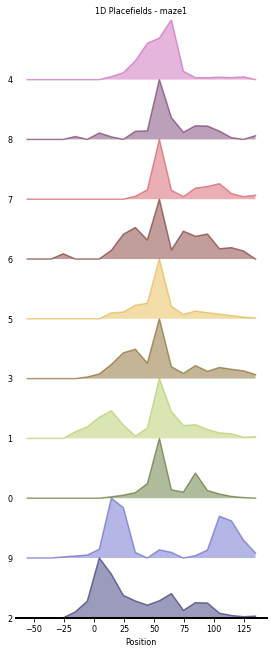

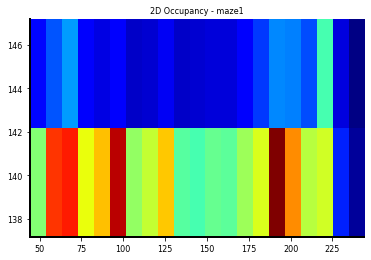

Saving 2D Placefield image out to "output\2006-6-07_11-26-53\maze1\2D Occupancy - maze1.pdf"...
	 done.
Saving 2D Placefield image out to "output\2006-6-07_11-26-53\maze1\2D Placefields - maze1.pdf"...
	 done.
good_placefield_neuronIDs: [ 3  5 18 22 24 28 39 44 45 55]; (10 good)


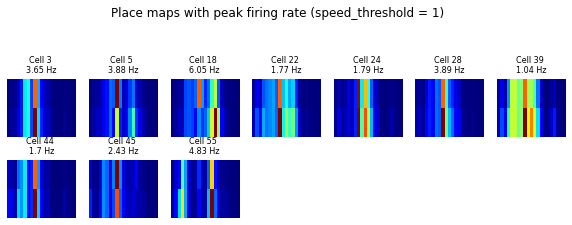

In [34]:
try: active_lap_only_placefields1D
except NameError: active_lap_only_placefields1D = None # Checks variable active_epoch_placefields's existance, and sets its value to None if it doesn't exist so it can be checked in the next step
try: active_lap_only_placefields2D
except NameError: active_lap_only_placefields2D = None # Checks variable active_epoch_placefields's existance, and sets its value to None if it doesn't exist so it can be checked in the next step
lap_specific_config = active_config
active_lap_only_placefields1D, active_lap_only_placefields2D = compute_placefields_as_needed(active_lap_specific_epoch_session, lap_specific_config.computation_config, lap_specific_config, active_lap_only_placefields1D, active_lap_only_placefields2D, should_force_recompute_placefields=True, should_display_2D_plots=True)
# Focus on the 2D placefields:
active_lap_only_placefields = active_lap_only_placefields2D
# Get the updated session using the units that have good placefields
lap_specific_session, lap_specific_config, lap_specific_good_placefield_neuronIDs = process_by_good_placefields(active_lap_specific_epoch_session, lap_specific_config, active_lap_only_placefields)

## Debug

In [ ]:
debug_print_spike_counts(active_epoch_session)
# active_epoch_session.spikes_df unique aclu values: [ 2  3  4  5  7  8  9 10 11 12 14 17 18 21 22 23 24 25 26 27 28 29 33 34
#  38 39 42 44 45 46 47 48 53 55 57 58 61 62 63 64]
# active_epoch_session.spikes_df unique aclu value counts: [   0    0  513  473   33  630    0  130  100  631   70  150  349    0
#    52    0    0  308  952    0    0 1436  898  342  223   89  109 1261
#   684  916    0    0    0  137  293    0    0    0  687  394    0    0
#   225    0  495 2123  316  111  396    0    0    0    0  458    0  576
#     0  927  382    0    0   89   90   55  370]
# active_epoch_session.spikes_df unique unit_id values: [ 0  1  2  3  5  6  7  8  9 10 12 15 16 19 20 21 22 23 24 25 26 27 31 32
#  36 37 40 42 43 44 45 46 51 53 55 56 59 60 61 62]
# active_epoch_session.spikes_df unique unit_id value counts: [ 513  473   33  630    0  130  100  631   70  150  349    0   52    0
#     0  308  952    0    0 1436  898  342  223   89  109 1261  684  916
#     0    0    0  137  293    0    0    0  687  394    0    0  225    0
#   495 2123  316  111  396    0    0    0    0  458    0  576    0  927
#   382    0    0   89   90   55  370]


# print(active_epoch_session.epochs.to_dataframe())
# print(sess.spikes_df) # max is in 4.2305 x 10^4
# print(sess.position.to_dataframe()) # max is in 4.2305 x 10^4 ## NOTE: The only place that I need to be careful with indexing is with sess.position properties, as these appear to be represented in terms of the number of 60Hz samples instead of in seconds like the Neurons and other classes.
# print(sess.flattened_spiketrains.spikes_df) # t_seconds is in the same units as the position dataframe, which is NOT seconds, and 't' is a factor of 1x10^4 larger than 't_seconds'
# # Get only the rows with a lap != -1:
# # spikes_df = spikes_df[(spikes_df.lap != -1)] # 229887 rows × 13 columns
# # spikes_df # 932598 rows × 14 columns

In [ ]:
print('pix2cm: {}'.format(DataSessionLoader.pix2cm))

In [ ]:
active_epoch_session.spikes_df

In [ ]:
debug_print_spike_counts(active_epoch_session) # 46 neurons after filtering, much better

# count_arr = np.bincount(active_epoch_session.spikes_df['unit_id'])
# count_arr
valid_indicies = np.nonzero(active_epoch_session.spikes_df['unit_id'].values)
valid_indicies
# count_arr = np.bincount(active_epoch_session.spikes_df['aclu'])
# count_arr

# len(active_epoch_session.spikes_df['unit_id'].values) # 17766
active_epoch_session.neurons.n_spikes

# active_epoch_session.neurons.n_spikes # array([ 513,  473,   33,  630,  130,  631,  150,  349,  308,  952, 1436,
#         # 898,  342,  223, 1261,  684,  916,  137,  293,  687,  394,  225,
#         # 495, 2123,  316,  111,  396,  458,  576,  927,  382])
        
# array([   0,    0,  513,  473,   33,  630,    0,  130,    0,  631,    0,
#         150,  349,    0,    0,    0,    0,  308,  952,    0,    0, 1436,
#         898,  342,  223,    0,    0, 1261,  684,  916,    0,    0,    0,
#         137,  293,    0,    0,    0,  687,  394,    0,    0,  225,    0,
#         495, 2123,  316,  111,  396,    0,    0,    0,    0,  458,    0,
#         576,    0,  927,  382], dtype=int64)

# active_epoch_placefields.spk_pos

In [44]:
active_lap_specific_epoch_session.spikes_df[['x','y']].to_numpy().T

,t,t_seconds,t_rel_seconds,shank,cluster,aclu,qclu,x,y,speed,traj,lap,maze_relative_lap,maze_id,cell_type,flat_spike_idx,x_loaded,y_loaded,linear_pos,unit_id
15867,962712.0,506947.210546,29.574497,7,10,45,4,233.433014,144.611866,8.450739,7,1,1,1,NeuronType.PYRAMIDAL,15867,0.826601,0.502357,-50.814215,43
15911,965053.0,506947.282462,29.646413,7,7,42,4,232.674691,144.014779,16.963930,4,1,1,1,NeuronType.PYRAMIDAL,15911,0.820252,0.500481,-49.838146,40
15952,967194.0,506947.348233,29.712184,2,20,21,4,230.939333,143.285457,31.656273,4,1,1,1,NeuronType.PYRAMIDAL,15952,0.812468,0.495902,-48.403477,19
15963,967827.0,506947.367679,29.731630,2,20,21,4,230.330199,143.055471,32.827359,4,1,1,1,NeuronType.PYRAMIDAL,15963,0.810061,0.494359,-47.920400,19
15984,968681.0,506947.393914,29.757865,2,20,21,4,229.530311,142.763385,32.679340,4,1,1,1,NeuronType.PYRAMIDAL,15984,0.807196,0.492691,-47.280543,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
810038,55066548.0,508609.279537,1691.643488,2,5,14,4,42.071771,139.257908,8.760465,4,41,41,1,NeuronType.PYRAMIDAL,810038,0.178959,0.477876,140.351508,12
810039,55066583.0,508609.280613,1691.644564,2,21,22,2,42.062645,139.255590,8.759254,4,41,41,1,NeuronType.PYRAMIDAL,810039,0.178937,0.477885,140.360430,20
810040,55066584.0,508609.280643,1691.644594,1,8,5,2,42.062384,139.255524,8.759220,4,41,41,1,NeuronType.PYRAMIDAL,810040,0.178936,0.477885,140.360685,3
810045,55067142.0,508609.297785,1691.661736,1,8,5,2,41.916707,139.218517,8.763511,4,41,41,1,NeuronType.PYRAMIDAL,810045,0.178654,0.478056,140.498283,3


## Main Spike/Placemap plotting:

# 3D Plots

## Tuning Curves 3D Plot:

In [53]:
from PhoGui.InteractivePlotter.InteractivePlaceCellTuningCurvesDataExplorer import InteractivePlaceCellTuningCurvesDataExplorer
try: pActiveTuningCurvesPlotter
except NameError: pActiveTuningCurvesPlotter = None # Checks variable p's existance, and sets its value to None if it doesn't exist so it can be checked in the next step
ipcDataExplorer = InteractivePlaceCellTuningCurvesDataExplorer(active_config, active_epoch_session, active_epoch_placefields, active_config.plotting_config.pf_colors, extant_plotter=pActiveTuningCurvesPlotter)
pActiveTuningCurvesPlotter = ipcDataExplorer.plot(pActiveTuningCurvesPlotter) # [2, 17449]

Applying custom Pyvista theme.
done.
No open BackgroundPlotter
Creating a new BackgroundPlotter


C:\Users\Pho\repos\NeuroPy\neuropy\utils\mathutil.py:23: RuntimeWarning: invalid value encountered in true_divide
  return (x - np.min(x, axis=axis, keepdims=True)) / np.ptp(


num_curr_tuning_curves: 40
	 num_cells_included: 39
	 num_cells_included: 39
	 num_cells_included: 39
	 num_cells_included: 39
	 num_cells_included: 1
	 num_cells_included: 39
	 num_cells_included: 39
	 num_cells_included: 39
	 num_cells_included: 39
	 num_cells_included: 39
	 num_cells_included: 39
	 num_cells_included: 39
	 num_cells_included: 39
	 num_cells_included: 39
	 num_cells_included: 39
	 num_cells_included: 39
	 num_cells_included: 39
	 num_cells_included: 39
	 num_cells_included: 39
	 num_cells_included: 39
	 num_cells_included: 39
	 num_cells_included: 39
	 num_cells_included: 39
	 num_cells_included: 39
	 num_cells_included: 39
	 num_cells_included: 39
	 num_cells_included: 39
	 num_cells_included: 39
	 num_cells_included: 39
	 num_cells_included: 39
	 num_cells_included: 39
	 num_cells_included: 39
	 num_cells_included: 39
	 num_cells_included: 39
	 num_cells_included: 39
	 num_cells_included: 39
	 num_cells_included: 39
	 num_cells_included: 39
	 num_cells_included: 39

In [55]:
## Getting the proper z-position for the tuning curve:
# Create source to ray trace
sphere = pv.Sphere(radius=0.85)

# Define a list of origin points and a list of direction vectors for each ray
# vectors = [ [cos(radians(x)), sin(radians(x)), 0] for x in range(0, 360, 5)]

# origins = [[0, 0, 0]] * len(active_lap_specific_epoch_session.spikes_df['x'])
# origins = np.hstack(active_lap_specific_epoch_session.spikes_df[['x','y']].to_numpy().T, np.full_like(active_lap_specific_epoch_session.spikes_df['x'].to_numpy(), 0.0))
# origins[0,:]
# spike_series_identities = active_flattened_spike_identities # currently unused

vectors = [[0, 0, 10.0]] * len(active_lap_specific_epoch_session.spikes_df['x']) # just up in the z-direction
spike_series_positions = active_lap_specific_epoch_session.spikes_df[['x','y']].to_numpy().T    
z_fixed = np.full_like(spike_series_positions[0,:], 1.1) # Offset a little bit in the z-direction so we can see it
origins = np.vstack((spike_series_positions[0,:], spike_series_positions[1,:], z_fixed)).T
# origins

# Perform ray trace
# Define line segment
# start = [0, 0, 0]
# stop = [0.25, 1, 0.5]

curr_idx = 0
curr_tuning_curve_mesh = ipcDataExplorer.plots['tuningCurvePlotActors'][curr_idx]
start = origins[curr_idx]
stop = start + vectors[curr_idx]

# Perform ray trace
# points, ind = sphere.ray_trace(start, stop)
points, ind = curr_tuning_curve_mesh.ray_trace(start, stop)
pActiveTuningCurvesPlotter.add_mesh(ray, color="blue", line_width=5, name='test_ray', label="Ray Segment")
pActiveTuningCurvesPlotter.add_mesh(intersection, color="maroon",
           point_size=25, label="Intersection Points", name='test_ray_intersection')
# points, ind_ray, ind_tri = sphere.multi_ray_trace(origins, vectors)

AttributeError: 'vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor' object has no attribute 'ray_trace'

## Interactive 3D Spike and Behavior Browser: 

In [ ]:
import PhoGui
from PhoGui.InteractivePlotter.PhoInteractivePlotter import PhoInteractivePlotter
from PhoGui.InteractivePlotter.shared_helpers import InteractivePyvistaPlotterBuildIfNeededMixin
from PhoGui.InteractivePlotter.InteractivePlaceCellDataExplorer import InteractivePlaceCellDataExplorer

active_config.plotting_config.show_legend = True

try: pActiveInteractivePlaceSpikesPlotter
except NameError: pActiveInteractivePlaceSpikesPlotter = None # Checks variable p's existance, and sets its value to None if it doesn't exist so it can be checked in the next step
ipspikesDataExplorer = InteractivePlaceCellDataExplorer(active_config, active_epoch_session, extant_plotter=pActiveInteractivePlaceSpikesPlotter)
pActiveInteractivePlaceSpikesPlotter = ipspikesDataExplorer.plot(pActivePlotter=pActiveInteractivePlaceSpikesPlotter)

## Debugging Index Issues:

In [ ]:
# def plot_placefields2D(pTuningCurves, active_placefields, pf_colors: np.ndarray, zScalingFactor=10.0, show_legend=False):

#     # .threshold().elevation()

#     curr_tuning_curves = active_placefields.ratemap.normalized_tuning_curves
#     # curr_tuning_curves[curr_tuning_curves < 0.1] = np.nan
#     curr_tuning_curves = curr_tuning_curves * zScalingFactor

#     num_curr_tuning_curves = len(curr_tuning_curves)
#     # Get the cell IDs that have a good place field mapping:
#     good_placefield_neuronIDs = np.array(active_placefields.ratemap.neuron_ids) # in order of ascending ID
#     tuningCurvePlot_x, tuningCurvePlot_y = np.meshgrid(active_placefields.ratemap.xbin_centers, active_placefields.ratemap.ybin_centers)

#     pdata_currActiveNeuronTuningCurve = pv.StructuredGrid(tuningCurvePlot_x, tuningCurvePlot_y, curr_active_neuron_tuning_Curve)
#     pdata_currActiveNeuronTuningCurve["Elevation"] = curr_active_neuron_tuning_Curve.ravel(order="F")
        
#     return pTuningCurves

# plot_placefields2D(pTuningCurves, active_epoch_placefields

# ipcDataExplorer.plots['spikes_pf_active']['cellID']

# only_active_colormap = ipcDataExplorer.active_config.plotting_config.active_cells_listed_colormap.copy()
# only_active_colormap
test_full_pc_data = ipcDataExplorer.plots_data['spikes_pf_active']['historical_spikes_pc']

# test_subset = test_full_pc_data.GetCellGhostArray()
# test_subset = test_full_pc_data.GetCellData() # vtkmodules.vtkCommonDataModel.vtkCellData
# test_subset = test_full_pc_data[test_full_pc_data['cellID'] == 55] # vtkmodules.vtkCommonDataModel.vtkCellData

# test_subset = test_full_pc_data.GetGhostArray() # [test_full_pc_data['cellID'] == 55] # vtkmodules.vtkCommonDataModel.vtkCellData


unique_ids = np.unique(test_full_pc_data['cellID']) # array([ 0,  1,  2,  3,  5,  7,  9, 10, 15, 16, 19, 20, 21, 22, 25, 26, 27, 31, 32, 36, 37, 40, 42, 43, 44, 45, 46, 51, 53, 55, 56])
# count_arr = np.bincount(test_full_pc_data['cellID'])
count_arr
# array([ 3591,  3311,   231,  4410,     0,   910,     0,  4417,     0,
#         1050,  2443,     0,     0,     0,     0,  2156,  6664,     0,
#            0, 10052,  6286,  2394,  1561,     0,     0,  8827,  4788,
#         6412,     0,     0,     0,   959,  2051,     0,     0,     0,
#         4809,  2758,     0,     0,  1575,     0,  3465, 14861,  2212,
#          777,  2772,     0,     0,     0,     0,  3206,     0,  4032,
#            0,  6489,  2674], dtype=int64)

# good_placefield_neuronIDs: [  5   8  10  13  14  16  19  21  23  25  28  31  32  33  36  37  41  49
#   52  53  54  55  57  59  60  61  62  63  64  66  68  69  74  75  76  78
#   83  86  88  89  90  92  96  98 105 108]; (46 good)

# 1, 4, 6, 7, 8, 11, 18, 19, 21 ## CONCLUSION: the ones that work are indeed the non-zero entries, but the checkboxes work in reverse order to this array that's printed. Meaning you start at the end and work back.
# len(count_arr) # 107
print(unique_ids) # [  3   6   8  11  12  14  17  19  21  23  26  29  30  31  34  35  39  47
  # 50  51  52  53  55  57  58  59  60  61  62  64  66  67  72  73  74  76
  # 81  84  86  87  88  90  94  96 103 106]


# uniques, indicies, inverse_indicies, count_arr = np.unique(active_epoch_session.spikes_df['aclu'].values, return_index=True, return_inverse=True, return_counts=True)
# # count_arr = np.bincount(active_epoch_session.spikes_df['aclu'].values)
# print('active_epoch_session.spikes_df unique aclu values: {}'.format(uniques))
# print('active_epoch_session.spikes_df unique aclu value counts: {}'.format(count_arr))
# print(len(uniques)) # 46 
# uniques, indicies, inverse_indicies, count_arr = np.unique(active_epoch_session.spikes_df['unit_id'].values, return_index=True, return_inverse=True, return_counts=True)
# # count_arr = np.bincount(active_epoch_session.spikes_df['unit_id'].values)
# print('active_epoch_session.spikes_df unique unit_id values: {}'.format(uniques))
# print('active_epoch_session.spikes_df unique unit_id value counts: {}'.format(count_arr))
# print(len(uniques)) # 46 

In [ ]:
# pActiveTuningCurvesPlotter.export_obj('export.obj')
# pActiveTuningCurvesPlotter.export_gltf('export.gltf')

ipcDataExplorer.update_placefield_spike_visibility([38], True) # seems to work

In [ ]:
ipcDataExplorer.update_placefield_spike_visibility([53], True) # seems to work

In [ ]:
ipcDataExplorer.update_placefield_spike_visibility([44, 53], True) # seems to work

# test_subset
# test_subset

In [ ]:
ipcDataExplorer.update_placefield_spike_visibility([53, 44], False) # seems to work

In [ ]:
ipcDataExplorer.gui['tuningCurveSpikeVisibilityCallbacks'][1](False)
# ipcDataExplorer.get_cell_index([2, 3])

In [ ]:
mesh = ipcDataExplorer.plots_data['spikes_pf_active']['historical_spikes_pc'].cast_to_unstructured_grid()
# mesh.n_cells
mesh_unique_ids = np.unique(mesh['cellID'])
print('n_cells: {}'.format(mesh.n_cells)) # 122143
print('cellIDs of mesh: {}'.format(mesh_unique_ids))
# np.unique(mesh['cellID']) # array([ 0,  1,  2,  3,  5,  7,  9, 10, 15, 16, 19, 20, 21, 22, 25, 26, 27, 31, 32, 36, 37, 40, 42, 43, 44, 45, 46, 51, 53, 55, 56])
# ipcDataExplorer.hide_placefield_spikes([0,1,2,3], should_invert=True)
# ipcDataExplorer.hide_placefield_spikes([23,2,34], should_invert=True)

# ipcDataExplorer.hide_placefield_spikes([34], should_invert=True)
ipcDataExplorer.hide_placefield_spikes([38], should_invert=False)

In [ ]:
# the list of spike times that occured for this cell:
i = 2
active_epoch_session.neurons.neuron_ids[i]
active_epoch_session.neurons.spiketrains[i]

# spikes_df = FlattenedSpiketrains.build_spike_dataframe(sess)


In [ ]:
## Timestamp Fixing:
def tt(position_timestamps, t_begin, SampleRate):
    return ((position_timestamps - t_begin) / (1e6 * SampleRate))

# sess.laps.lap_start_stop_flat_idx

sess.recinfo.dat_sampling_rate


# Programmatically change the animal position trail:

In [ ]:
int_input = pn.widgets.IntInput(name='IntInput', value=5, step=1, start=0, end=20)
curr_lap_id = int_input.value
int_input


In [ ]:
def get_lap_position(curr_lap_id):
    curr_position_df = sess.position.to_dataframe()
    curr_lap_t_start, curr_lap_t_stop = get_lap_times(curr_lap_id)
    print('lap[{}]: ({}, {}): '.format(curr_lap_id, curr_lap_t_start, curr_lap_t_stop))

    curr_lap_position_df_is_included = curr_position_df['t'].between(curr_lap_t_start, curr_lap_t_stop, inclusive=True) # returns a boolean array indicating inclusion in teh current lap
    curr_lap_position_df = curr_position_df[curr_lap_position_df_is_included] 
    # curr_position_df.query('-0.5 <= t < 0.5')
    curr_lap_position_traces = curr_lap_position_df[['x','y']].to_numpy().T
    print('\t {} positions.'.format(np.shape(curr_lap_position_traces)))
    # print('\t {} spikes.'.format(curr_lap_num_spikes))
    return curr_lap_position_traces

# ipspikesDataExplorer.on_programmatic_data_update(active_included_all_historical_indicies=curr_lap_spike_indicies, active_included_recent_only_indicies=curr_lap_spike_indicies) # index 145937 is out of bounds for axis 0 with size 19647
# ipspikesDataExplorer.on_programmatic_data_update(active_included_all_historical_indicies=curr_lap_spike_t_seconds, active_included_recent_only_indicies=curr_lap_spike_t_seconds) # 
# ipspikesDataExplorer.on_programmatic_data_update(active_included_all_historical_indicies=curr_lap_spike_t_seconds.values, active_included_recent_only_indicies=curr_lap_spike_t_seconds.values) # 

curr_lap_id = int_input.value

# plot_lap_trajectory_path(ipspikesDataExplorer, curr_lap_position_traces)
plot_lap_trajectory_path_spline(ipspikesDataExplorer, curr_lap_position_traces)
# curr_lap_t_start
## TODO: enable showing/hiding the spikes for this data range programmatically in InteractivePlaceCellDataExplorer. 
# ipspikesDataExplorer.
# curr_lap_spike_t_seconds
# curr_lap_spike_indicies
# active_epoch_session.flattened_spiketrains.spikes_df.t_seconds.values[curr_lap_spike_indicies] # index 145937 is out of bounds for axis 0 with size 19647

In [100]:
# From the laps and position dataframe, extract which lap every position belongs to:

# curr_lap_position_df_is_included = curr_position_df['t'].between(laps_df['start'], laps_df['stop'], inclusive=True) # returns a boolean array indicating inclusion in teh current lap
# curr_lap_position_df = curr_position_df[curr_lap_position_df_is_included] 
# curr_position_df['lap'] = np.NaN

curr_position_df = sess.compute_position_laps()
# curr_position_df.groupby('lap').groups[1] # returns the Int64Index
curr_position_df.groupby('lap').get_group(2)[['t','x','y','lin_pos']]

lap_specific_position_dfs = [curr_position_df.groupby('lap').get_group(i)[['t','x','y','lin_pos']] for i in sess.laps.lap_id]
lap_specific_position_dfs
curr_lap_position_traces = [lap_pos_df[['x','y']].to_numpy().T for lap_pos_df in lap_specific_position_dfs]
curr_lap_position_traces
curr_lap_time_range = [[lap_pos_df[['t']].to_numpy()[0].item(), lap_pos_df[['t']].to_numpy()[-1].item()] for lap_pos_df in lap_specific_position_dfs]
curr_lap_time_range

In [36]:
from PhoPositionalData.plotting.spikeAndPositions import build_active_spikes_plot_data, perform_plot_flat_arena
from PhoGui.InteractivePlotter.LapsVisualizationMixin import LapsVisualizationMixin
from PhoGui.PhoCustomVtkWidgets import PhoWidgetHelper
from itertools import islice # for Pagination class


# class Pagination:
#     def __init__(self, num_items: int, page_capacity: int):
#         self.num_items = num_items
#         self.num_items_per_page = page_capacity
        
#         self.num_pages = np.ceil(self.num_items / self.num_items_per_page)
#         # generate the pages
#         # [list(chunk) for chunk in chunks(zip(cities, states), 3)]
#         # np.

def plot_lap_trajectories_3d(sess, curr_num_subplots=5, active_page_index=0):
    """ Plots a PyVista Qt Multiplotter with each lap being shown in one of its subplots """
    def _chunks(iterable, size=10):
        iterator = iter(iterable)
        for first in iterator:    # stops when iterator is depleted
            def chunk():          # construct generator for next chunk
                yield first       # yield element from for loop
                for more in islice(iterator, size - 1):
                    yield more    # yield more elements from the iterator
            yield chunk()         # in outer generator, yield next chunk

    def _compute_laps_position_data(sess):
        curr_position_df = sess.compute_position_laps()
        lap_specific_position_dfs = [curr_position_df.groupby('lap').get_group(i)[['t','x','y','lin_pos']] for i in sess.laps.lap_id] # dataframes split for each ID:
        return curr_position_df, lap_specific_position_dfs
        
    def _build_laps_multiplotter(nfields, linear_plot_data=None):
        linear_plotter_indicies = np.arange(nfields)
        fixed_columns = 5
        needed_rows = int(np.ceil(nfields / fixed_columns))
        row_column_indicies = np.unravel_index(linear_plotter_indicies, (needed_rows, fixed_columns)) # inverse is: np.ravel_multi_index(row_column_indicies, (needed_rows, fixed_columns))
        mp = pvqt.MultiPlotter(nrows=needed_rows, ncols=fixed_columns, show=False, title='Laps Muliplotter', toolbar=False, menu_bar=False, editor=False)
        # print('linear_plotter_indicies: {}\n row_column_indicies: {}\n'.format(linear_plotter_indicies, row_column_indicies))
        for a_linear_index in linear_plotter_indicies:
            # print('a_linear_index: {}, row_column_indicies[0][a_linear_index]: {}, row_column_indicies[1][a_linear_index]: {}'.format(a_linear_index, row_column_indicies[0][a_linear_index], row_column_indicies[1][a_linear_index]))
            curr_row = row_column_indicies[0][a_linear_index]
            curr_col = row_column_indicies[1][a_linear_index]
            if linear_plot_data is None:
                mp[curr_row, curr_col].add_mesh(pv.Sphere())
            else:
                mp[curr_row, curr_col].add_mesh(linear_plot_data[a_linear_index], name='maze_bg', color="black", render=False)
        return mp, linear_plotter_indicies, row_column_indicies

    # Plot the flat arena
    # flat_maze_bg_plot = perform_plot_flat_arena(self.p, self.x, self.y, bShowSequenceTraversalGradient=False)
    def __build_flat_map_plot_data(x, y):
        # Builds the flat base maze map that the other data will be plot on top of
        z = np.zeros_like(x)
        point_cloud = np.vstack((x, y, z)).T
        pdata = pv.PolyData(point_cloud)
        pdata['occupancy heatmap'] = np.arange(np.shape(point_cloud)[0])
        geo = pv.Circle(radius=0.5)
        pc = pdata.glyph(scale=False, geom=geo)
        return pdata, pc
    
    def _add_specific_lap_trajectory(p, linear_plotter_indicies, row_column_indicies, active_page_laps_ids, curr_lap_position_traces, curr_lap_time_range):
        # Add the lap trajectory:
        for a_linear_index in linear_plotter_indicies:
            curr_lap_id = active_page_laps_ids[a_linear_index]
            curr_row = row_column_indicies[0][a_linear_index]
            curr_col = row_column_indicies[1][a_linear_index]
            LapsVisualizationMixin.plot_lap_trajectory_path_spline(p[curr_row, curr_col], curr_lap_position_traces[curr_lap_id], a_linear_index)
            curr_lap_label_text = 'Lap[{}]: t({:.2f}, {:.2f})'.format(curr_lap_id, curr_lap_time_range[curr_lap_id][0], curr_lap_time_range[curr_lap_id][1]) 
            PhoWidgetHelper.perform_add_text(p[curr_row, curr_col], curr_lap_label_text, name='lblLapIdIndicator')

    # Compute required data from session:
    curr_position_df, lap_specific_position_dfs = _compute_laps_position_data(sess)
    curr_lap_position_traces = [lap_pos_df[['x','y']].to_numpy().T for lap_pos_df in lap_specific_position_dfs]
    curr_lap_time_range = [[lap_pos_df[['t']].to_numpy()[0].item(), lap_pos_df[['t']].to_numpy()[-1].item()] for lap_pos_df in lap_specific_position_dfs]

    all_maze_positions = curr_position_df[['x','y']].to_numpy().T # (2, 59308)
    # np.shape(all_maze_positions)
    pdata_maze_shared, pc_maze_shared = __build_flat_map_plot_data(all_maze_positions[0,:], all_maze_positions[1,:])
    all_maze_data = np.full((curr_num_subplots,), pc_maze_shared) # repeat the maze data for each subplot
    p, linear_plotter_indicies, row_column_indicies = _build_laps_multiplotter(curr_num_subplots, all_maze_data)
    # generate the pages
    # laps_pages = [list(chunk) for chunk in chunks(zip(sess.laps.lap_id, linear_plotter_indicies, row_column_indicies), curr_num_subplots)]
    laps_pages = [list(chunk) for chunk in _chunks(sess.laps.lap_id, curr_num_subplots)]
    active_page_laps_ids = laps_pages[active_page_index]
    _add_specific_lap_trajectory(p, linear_plotter_indicies, row_column_indicies, active_page_laps_ids, curr_lap_position_traces, curr_lap_time_range)
    return p, laps_pages



p, laps_pages = plot_lap_trajectories_3d(sess, curr_num_subplots=10, active_page_index=1)
p.show()

## CustomDataExplorer 3D Plotter:

In [37]:
from PhoGui.InteractivePlotter.InteractiveCustomDataExplorer import InteractiveCustomDataExplorer
active_laps_config = InteractivePlaceCellConfig(active_session_config=sess.config, active_epochs=None, video_output_config=None, plotting_config=None) # '3|1    
active_laps_config.plotting_config = PlottingConfig(output_subplots_shape='1|5', output_parent_dir=Path('output', sess.config.session_name, 'custom_laps'))

try: pActiveInteractiveLapsPlotter
except NameError: pActiveInteractiveLapsPlotter = None # Checks variable p's existance, and sets its value to None if it doesn't exist so it can be checked in the next step
iplapsDataExplorer = InteractiveCustomDataExplorer(active_laps_config, sess, extant_plotter=pActiveInteractiveLapsPlotter)
pActiveInteractiveLapsPlotter = iplapsDataExplorer.plot(pActivePlotter=pActiveInteractiveLapsPlotter)

Applying custom Pyvista theme.
done.
No extant BackgroundPlotter
Creating a new BackgroundPlotter


In [ ]:
# surf = points.reconstruct_surface()

def perform_plot_flat_arena(p, x, y, bShowSequenceTraversalGradient=False):
    # Call with:
    # pdata_maze, pc_maze = build_flat_map_plot_data() # Plot the flat arena
    # p.add_mesh(pc_maze, name='maze_bg', color="black", render=False)
    def __build_flat_map_plot_data(x, y):
        # Builds the flat base maze map that the other data will be plot on top of
        ## Implicitly relies on: x, y
        z = np.zeros_like(x)
        point_cloud = np.vstack((x, y, z)).T
        pdata = pv.PolyData(point_cloud)
        pdata['occupancy heatmap'] = np.arange(np.shape(point_cloud)[0])
        geo = pv.Circle(radius=0.5)
        pc = pdata.glyph(scale=False, geom=geo)
        return pdata, pc

    pdata_maze, pc_maze = __build_flat_map_plot_data(x, y)
    surf = pdata_maze.reconstruct_surface()
    
    return p.add_mesh(pc_maze, name='maze_bg', label='maze', color="black", render=True)    
    # # bShowSequenceTraversalGradient
    # if bShowSequenceTraversalGradient:
    #     traversal_order_scalars = np.arange(len(x))
    #     return p.add_mesh(pc_maze, name='maze_bg', label='maze', scalars=traversal_order_scalars, render=True)

iplapsDataExplorer.plots['maze_bg'] = perform_plot_flat_arena(pActiveInteractiveLapsPlotter, iplapsDataExplorer.x, iplapsDataExplorer.y)



In [62]:
len(sess.laps.lap_id) # 44

44

In [ ]:
for i in np.arange(len(sess.laps.lap_id)):
    curr_lap_id = sess.laps.lap_id[i]
    curr_lap_t_start, curr_lap_t_stop = sess.laps.get_lap_times(i)
    curr_lap_position_traces = laps_position_traces[i]
    plot_lap_trajectory_path_spline(iplapsDataExplorer, curr_lap_position_traces, curr_lap_id)

In [ ]:
# p = pv.Plotter(shape=(5, 1), border=True)
p = pActiveInteractiveLapsPlotter
num_laps_to_show = len(sess.laps.lap_id)
num_laps_to_show = 5
flat_lap_id_index = np.arange(len(sess.laps.lap_id))
# subplot_lap_id_index = np.reshape([4,11])
for i in np.arange(num_laps_to_show):
    curr_lap_id = sess.laps.lap_id[i]
    p.subplot(i, 0)
    # curr_lap_t_start, curr_lap_t_stop = sess.laps.get_lap_times(i)
    plot_lap_trajectory_path_spline(iplapsDataExplorer, laps_position_traces[i], curr_lap_id)
    
p.link_views()  # link all the views
p.show()

In [ ]:
# ipspikesDataExplorer.spikes_main_historical.SetVisibility(0)

# ipspikesDataExplorer.spikes_main_historical.SetVisibility(1)
# bool(ipspikesDataExplorer.spikes_main_historical.GetVisibility())

ipspikesDataExplorer.toggle_plot_visibility('spikes_main_historical')
# toggle_visibility(ipspikesDataExplorer.spikes_main_historical)

In [ ]:
ipspikesDataExplorer.toggle_plot_visibility('lap_location_trail')

In [ ]:
# ipspikesDataExplorer.spikes_main_recent_only.SetVisibility(True)
toggle_visibility(ipspikesDataExplorer.spikes_main_recent_only)

In [ ]:
# ipspikesDataExplorer.animal_location_trail.SetVisibility(0)
# toggle_visibility(ipspikesDataExplorer.animal_location_trail)
ipspikesDataExplorer.toggle_plot_visibility('animal_location_trail')
ipspikesDataExplorer.toggle_plot_visibility('animal_current_location_point')

# Programmatically change the animals location point indicator:

In [ ]:
# .GetPosition() returns the actor's position, which is usually (0.0, 0.0, 0.0), and does not relate to the actor's data points
# curr_animal_point = ipspikesDataExplorer.animal_location_trail.GetPosition()
# curr_animal_point = ipspikesDataExplorer.animal_location_trail.GetXRange() # (44.23604202270508, 245.9059600830078)
# print(curr_animal_point)
# curr_animal_point = ipspikesDataExplorer.animal_location_trail.GetYRange() # (135.27638244628906, 145.448974609375)
# print(curr_animal_point)
# curr_animal_point = ipspikesDataExplorer.animal_location_trail.GetZRange() # (1.100000023841858, 1.100000023841858)

curr_animal_point = np.array(ipspikesDataExplorer.animal_location_trail.GetCenter()) # (206.27755737304688, 140.15452575683594, 1.100000023841858)
print('curr_animal_point: {}'.format(curr_animal_point))
curr_animal_point # curr_animal_poin

# curr_animal_point = np.array([0, 0, 0])

# curr_animal_point = np.column_stack((self.x[active_window_sample_indicies], self.y[active_window_sample_indicies], self.z_fixed))
# ipspikesDataExplorer.on_programmatic_data_update(curr_animal_point=curr_animal_point)

curr_debug_point = np.array(ipspikesDataExplorer.animal_location_trail.GetCenter()) # (206.27755737304688, 140.15452575683594, 1.100000023841858)
ipspikesDataExplorer.perform_plot_location_point('debug_point_plot', curr_animal_point, color='r')

curr_animal_point = np.array(ipspikesDataExplorer.animal_location_trail.GetCenter()) # not updated
print('new curr_animal_point: {}'.format(curr_animal_point))

In [ ]:
# ipspikesDataExplorer.flattened_spike_positions_list

active_epoch_session.flattened_spiketrains.time_slice(curr_lap_spike_t_seconds.values[0], curr_lap_spike_t_seconds.values[-1]).spikes_df

In [ ]:
curr_lap_dataframe

In [ ]:
active_epoch_session.time_slice